## Multirate Signal Processing - Seminar 2

Improved filterbank using filter design techiques. 

Import the necessary libraries first.

In [1]:
import numpy as np
import sound
import scipy.signal as sig
import scipy.io.wavfile as wav
import scipy.fftpack as fft
import pyaudio
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,6]

Load audio file from folder data.

In [2]:
pathToAudio = "data/Track48.wav"
fs, data = wav.read(pathToAudio)
duration = 5 # seconds
audio = np.array(data[:fs*duration,0]) # use only one channel
print('Sampling rate: {}'.format(fs))
print('Data Type: ', audio.dtype)
print('Shape of one channel: {}'.format(audio.shape))

Sampling rate: 44100
Data Type:  int16
Shape of one channel: (220500,)


### From HW 1

Create filterbank using remez function.

In [3]:
filterTabs = 10
filterbank_remez = []
#lowpass
filterbank_remez.append(sig.remez(filterTabs,[0, 0.125, 0.15, 0.5],[1 , 0],[1, 1000]))
# bandpass low
filterbank_remez.append(sig.remez(filterTabs,[0, 0.1, 0.125, 0.25, 0.275, 0.5],[0, 1 , 0],[1000, 1, 1000]))
# bandpass high
filterbank_remez.append(sig.remez(filterTabs,[0, 0.225, 0.25, 0.375, 0.4, 0.5],[0, 1 , 0],[1000, 1, 1000]))
#highpass
filterbank_remez.append(sig.remez(filterTabs,[0, 0.35, 0.375, 0.5],[0, 1],[1000, 1]))

Plot filter impulse responses in one window

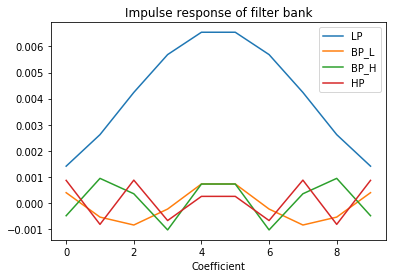

In [4]:
f1 = plt.figure()
for h in filterbank_remez:
    plt.plot(h)
plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Impulse response of filter bank')
plt.xlabel('Coefficient')
plt.show()

Plot filter frequency responses:

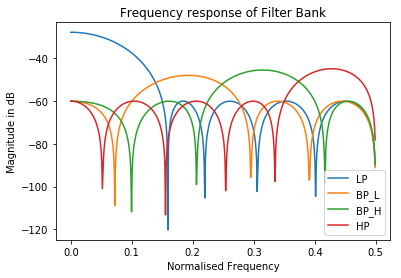

In [5]:
for h in filterbank_remez:
    w,H = sig.freqz(h)
    # plot magnitude
    plt.plot(w/(np.pi*2),20*np.log10(np.abs(H)))
plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Frequency response of Filter Bank')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')
plt.show()

### Design filters using windowing

Definition of helper functions:
* sinc
* impulse response of ideal lowpass (sincInpulse)
* Cosine modulator 

In [6]:
def sinc(x):
    return (np.sin(x)/x)

def sincImpulse(N,wc):
    n = np.arange(0,N)
    delay = (N-1)/2.0
    # h = (wc/np.pi) * (np.sin(wc *(n-delay))/(np.pi*(n-delay)))
    h = (wc/np.pi)*sinc((n-delay)*wc)
    return h

def cosModulator(N,w0):
    n = np.arange(0,N)
    # delay = (N-1)/2.0
    # m = (1/np.pi)*np.cos(w0*np.pi*(n-delay))
    m = np.cos(w0*n)
    return m

Definitions of window functions:
* raised cosine window
* sin window

In [7]:
def raisedCosWinow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        c = 0.5-0.5*np.cos(2*np.pi/N*(n+0.5))
    else: # odd
        c = 0.5-0.5*np.cos(2*np.pi/(N+1)*(n+1))    
    return c

def sinWindow(N):
    """ This is supposed to have a 0.0 at n<0 and n>=N"""
    n = np.arange(0,N)
    s = np.sin(((n+1)/(N+1)) * np.pi)
    return s

Create Lowpass filters:

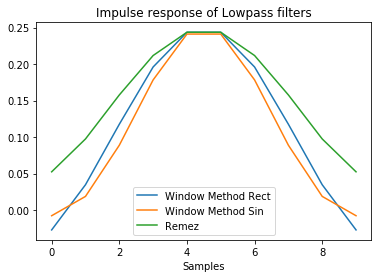

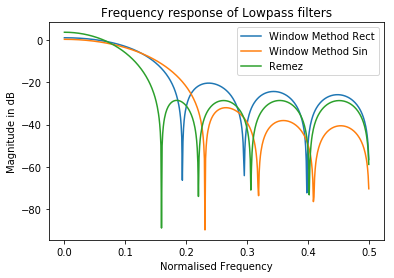

In [8]:
def lowpass(N, wc, wtype):
    """Lowpass filter with N taps and cutoff frequency wc in radians"""
    
    if (wtype == "rect"):
        window = np.ones(N) # rectangular window
    elif (wtype == "sin"):
        window = sinWindow(N) #sine window
    
    lp = sincImpulse(N, wc) * window
    return lp


lp_windowRect = lowpass(filterTabs, 0.25*np.pi, "rect")
lp_windowSin = lowpass(filterTabs, 0.25*np.pi, "sin")

lp_remez = sig.remez(filterTabs, [0, 0.125, 0.15, 0.5],[1 , 0],[1, 100])
lp_remez = lp_remez * (np.max(lp_windowRect) / np.max(lp_remez)) # scale for plotting

plt.plot(lp_windowRect)
plt.plot(lp_windowSin)
plt.plot(lp_remez)
plt.title('Impulse response of Lowpass filters')
plt.xlabel('Samples')
plt.legend(['Window Method Rect', 'Window Method Sin', 'Remez'])
plt.show()

w,H = sig.freqz(lp_windowRect)
plt.plot(w/(2*np.pi),20*np.log10(np.abs(H)))
wS,HS = sig.freqz(lp_windowSin)
plt.plot(wS/(2*np.pi),20*np.log10(np.abs(HS)))
wR,HR = sig.freqz(lp_remez)
plt.plot(wR/(2*np.pi),20*np.log10(np.abs(HR)))
plt.title('Frequency response of Lowpass filters')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')
plt.legend(['Window Method Rect', 'Window Method Sin', 'Remez'])

Construct Ideal high pass filter

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


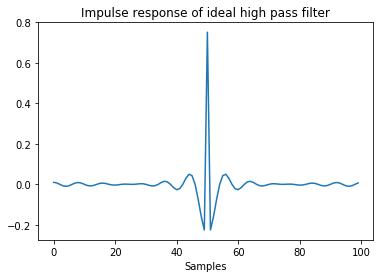

0.0199605345686


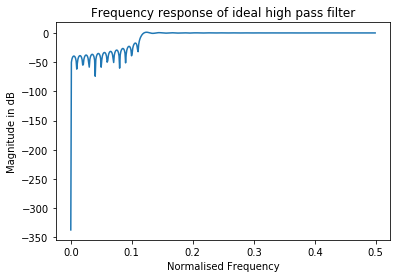

In [9]:
def construct_ideal_hp(N, wc):
    nd = int(N/2) 

    # construct magnitude response
    wcIdx = np.round((wc/np.pi)*(N/2)).astype(int)
    H_desired = np.concatenate([np.zeros(wcIdx), np.ones(nd-wcIdx)])

    # construct phase response = delay to make causal
    delay_t = np.concatenate([np.zeros(nd), [1], np.zeros(nd-1)])
    delay_f = fft.fft(delay_t)
    Ph_desired = np.angle(delay_f)

    # IFFT of constructed ideal hp
    H_desired = np.concatenate([H_desired, np.flipud(H_desired[:-1]), [H_desired[0]]])
    fresp_ideal = H_desired * np.exp(1j*Ph_desired)
    h = fft.ifft(fresp_ideal)
    return h

hp_ideal = construct_ideal_hp(100, 0.25*np.pi) #"infinitely" long equals 100k samples here
plt.plot(hp_ideal)
plt.title('Impulse response of ideal high pass filter')
plt.xlabel('Samples')
plt.show()

w,H = sig.freqz(hp_ideal)
plt.plot(w/(2*np.pi),20*np.log10(np.abs(H)))
plt.title('Frequency response of ideal high pass filter')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')

print(np.max(np.imag(hp_ideal)))

Create highpass filter out of ideal highpass

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


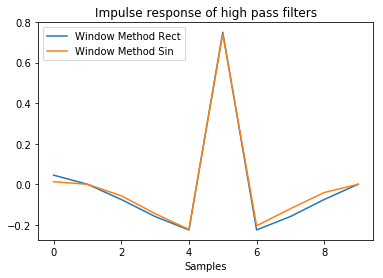

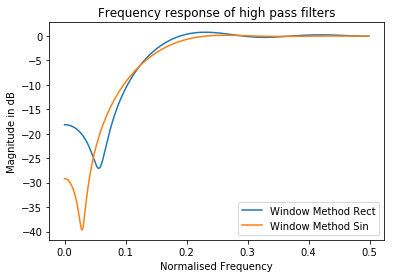

In [10]:
def highpass(N, wc, wtype):
    """Lowpass filter with N taps and cutoff frequency wc in radians"""
    
    if (wtype == "rect"):
        window = np.ones(N) # rectangular window
    elif (wtype == "sin"):
        window = sinWindow(N) #sine window
    
    ideal_hp = construct_ideal_hp(100000, wc) #"infinitely" long equals 100k samples here
    hp = ideal_hp[int(100000/2 - N/2) : int(100000/2 + N/2)] * window
    return hp

filterTabs = 10
hp_windowRect = highpass(filterTabs, 0.25*np.pi, "rect")
hp_windowSin = highpass(filterTabs, 0.25*np.pi, "sin")

plt.plot(hp_windowRect)
plt.plot(hp_windowSin)
plt.title('Impulse response of high pass filters')
plt.xlabel('Samples')
plt.legend(['Window Method Rect', 'Window Method Sin'])
plt.show()

w,H = sig.freqz(hp_windowRect)
plt.plot(w/(2*np.pi),20*np.log10(np.abs(H)))
wS,HS = sig.freqz(hp_windowSin)
plt.plot(wS/(2*np.pi),20*np.log10(np.abs(HS)))
plt.title('Frequency response of high pass filters')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')
plt.legend(['Window Method Rect', 'Window Method Sin', 'Remez'])

Filterbank implementation (as written in homework assignment)

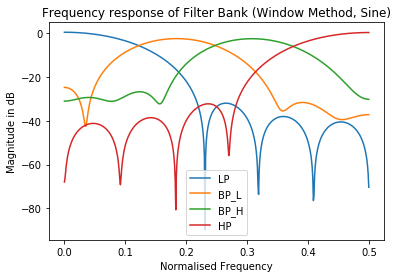

In [11]:
#construct filterbank
filterbank = []
filterTabs = 10
#lowpass
lp = lowpass(filterTabs, 0.25*np.pi, "sin")
filterbank.append(lp)
# bandpass low = highpass 0.25pi * lowpass 0.5pi
hp1 = highpass(filterTabs, 0.25*np.pi, "sin")
lp1 = lowpass(filterTabs, 0.5*np.pi, "sin")
bp1 = sig.convolve(hp1, lp1, "same")
filterbank.append(bp1)
# bandpass high = highpass 0.5pi * lowpass 0.75pi
hp2 = highpass(filterTabs, 0.5*np.pi, "sin")
lp2 = lowpass(filterTabs, 0.75*np.pi, "sin")
bp2 = sig.convolve(hp2, lp2, "same")
filterbank.append(bp2)
#highpass
hp = highpass(filterTabs, 0.75*np.pi, "sin")
filterbank.append(hp)

for idx, h in enumerate(filterbank):
    w,H = sig.freqz(h)
    plt.plot(w/(2*np.pi),20*np.log10(np.abs(H)))
plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Frequency response of Filter Bank (Window Method, Sine)')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')
plt.show()

Listen to filtered audio:

In [17]:
decomposed = [np.convolve(h,audio,mode='full') for h in filterbank]
for i, band in enumerate(decomposed):
    print("Playing {}th subband.".format(i))
    sound.sound(band,fs)

Playing 0th subband.
* done
Playing 1th subband.


/Users/gorgi/Documents/Dokumente - Georgs MacBook Pro/Studium/12_Semester/MultirateSignalProcessing/Seminar/MRSP_Git/sound.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  stream.write(samples.astype(np.int16),len(samples))


* done
Playing 2th subband.
* done
Playing 3th subband.
* done


Filterbank implementation (improved according to book):

In [13]:
def createFilterbank(nBands,nTabs):
    """Function to create a cosine modulated filterbank with nBands subbands and nTabs coefficients.
    It uses a raised cosine window function."""
    wLp = np.pi/(2*nBands)
    prototype = sincImpulse(nTabs, wLp) * raisedCosWinow(nTabs)
    fb = []
    for i in range(0,nBands):
        mod = cosModulator(nTabs, (2*i+1) * np.pi/(2*nBands))
        fb.append(2 * prototype * mod)
        
    return fb


In [14]:
FB = createFilterbank(4,104)

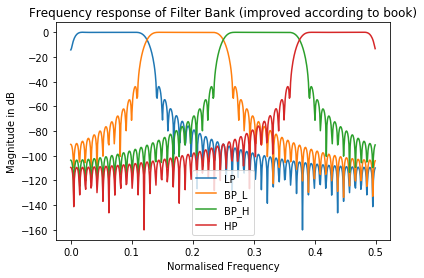

In [15]:
for h in FB:
    w,H = sig.freqz(h)
    plt.plot(w/(2*np.pi),20*np.log10(np.abs(H)))
plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Frequency response of Filter Bank (improved according to book)')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')
plt.show()

Listen to filtered audio:

In [16]:
decomposed = [np.convolve(h,audio,mode='full') for h in FB]
for i, band in enumerate(decomposed):
    print("Playing {}th subband.".format(i))
    sound.sound(band,fs)

Playing 0th subband.
* done
Playing 1th subband.
* done
Playing 2th subband.
* done
Playing 3th subband.
* done
